In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from general_functions import *
import matplotlib.pyplot as plt

$$\dot{\langle\phi_i(s|m)\rangle} = \frac{\mu}{N(N-1)M} \sum_{j≠i}\sum_{s^*}\phi_i(s^*|m)\left[\frac{2\phi_j(s^*|m)}{\sum_{\hat{m}}\phi_j(s^*|\hat{m})}-1\right]\phi_i(s^*|m)\left[1-\phi_i(s^*|m)\right]\left[\delta_{s,s^*}-\phi_i(s|m)\right]$$

$$\frac{\partial \vec{\phi}}{\partial t} = f(t, \vec{\phi})$$

In [2]:
N, S, M, mu = 2, 3, 3, 0.1

In [2]:
def func(t, phi, mu, N, S, M):
    
    phi_dot = np.zeros(N*S*M)

    for alpha in np.arange(N*S*M):
        i,s,m = get_ism(alpha, N=N, S=S, M=M)
        sum_of_terms = 0

        for j in range(N):
            if j==i: continue # omit the j=i case

            for s_ in range(S):
                delta_ss = 1 if s_==s else 0
                sum_denominator = 0
                for m_ in range(M): sum_denominator += phi[get_index(j, s_, m_, N=N, S=S, M=M)]

                sum_of_terms += mu/(N*(N-1)*M) * phi[get_index(i,s_,m, N=N, S=S, M=M)]**2 * (1 - phi[get_index(i,s_,m, N=N, S=S, M=M)]) * \
                                (2 * phi[get_index(j,s_,m, N=N, S=S, M=M)] / sum_denominator - 1) * (delta_ss - phi[alpha])

        phi_dot[alpha] = sum_of_terms 
    
    return phi_dot

In [15]:
def run_model_diffs(phi_init, phi_opt, tf, t_eval, N=N, S=S, M=M, mu=mu):

    # phi_init = phi_opt #suboptimal_grammar(phi_opt, N=N, S=S, M=M, epsilon=mu, method='uniform')
    phi = phi_init.copy()

    diffs = []

    for t in range(tf+1):

        intend = choose_meaning(M)
        speaker, listener = choose_agents(N, 'NN')
        produce = np.random.choice(S, p=phi[speaker,:,intend]) # the signal produced by the speaker
        infer = np.random.choice(M, p=phi[listener,produce,:] / np.sum(phi[listener,produce,:])) # the meaning inferred by the listener

        # updating phi
        feedback = get_feedback(mu, speaker, listener, intend, infer)
        phi[speaker,produce,intend] += (feedback * phi[speaker,produce,intend] * (1 - phi[speaker,produce,intend]))
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

        if t in t_eval: diffs.append(difference(phi_opt, phi))
    
    return diffs

phi_init = run_simple_model(N, S, M, lambd=mu, max_steps=10, get_phi=True)
print(phi_init)
y0 = phi_to_y(phi_init, N=N, S=S, M=M)


[[[0.34090909 0.34090909 0.34125771]
  [0.34090909 0.34090909 0.3185187 ]
  [0.31818182 0.31818182 0.34022359]]

 [[0.34057803 0.33333333 0.34025343]
  [0.31907514 0.33333333 0.34124254]
  [0.34034682 0.33333333 0.31850404]]]


In [16]:
### scipy.integrate.solve_ivp method

tf = 100000
y0 = phi_to_y(suboptimal_grammar(optimal_grammar(), epsilon=.1)) #np.ones(N*S*M)*1/S
sol = solve_ivp(func, t_span=[0, tf], t_eval=[0, tf], y0=y0, method='RK45', vectorized=True, args=(mu, N, M, S))

TypeError: optimal_grammar() missing 3 required positional arguments: 'N', 'S', and 'M'

when using a 'suboptimal' grammar (an optimal grammar with random noise that satisfies the constraint along the signal axis) we find that the deterministic equations (which are nonlinear) clearly make the system converge towards the 'ideal' optimal grammar. this result differs from the linear stability analysis performed on the same optimal grammar, for which it finds that the system is neutral to perturbations. we can thus deduce that the 'restoring force' responsible for the convergence towards optimal grammars originate from the nonlinear terms in the update rule (which are by definition ommitted from the LSA).

In [17]:
# methods to convert from 3D array to 1D array

y_initial, y_final = sol.y[:,0], sol.y[:,-1]
phi_initial, phi_final = y_to_phi(y_initial), y_to_phi(y_final)
A_init, A_final = intelligibility(phi_initial, N, S, M), intelligibility(phi_final, N, S, M)

# hi, lo = np.sum(y_final > 0.25), np.sum(y_final <= 0.25)
# print(hi, lo)

print(f'\nA initial = {A_init:.4f}\nA final   = {A_final:.4f}')

print(phi_initial)
print()
print(phi_final)

TypeError: y_to_phi() missing 3 required positional arguments: 'N', 'S', and 'M'

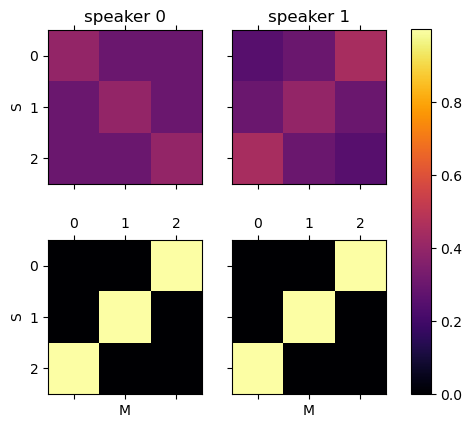

In [16]:
phi_initial = initiate_phi(N, S, M, method='diag_val', diag_val=0.4)
phi_initial[1,0,0] = 0.25
phi_initial[1,2,2] = 0.25
phi_initial[1,0,2] = 0.45
phi_initial[1,2,0] = 0.45
t_eval, phis = get_deterministic_predictions(N, S, M, mu, tf=5e6, phi_initial=phi_initial, get_intelligibility=False)
phi_final = phis[-1]

figsize = (5*(M/S), 5)
fig, axs = plt.subplots(ncols=N, nrows=2, figsize=figsize, sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    if i == 0 or i == N: ax.set_ylabel('S')
    if i < N: 
        im = ax.matshow(phi_initial[i,:,:], cmap='inferno', vmin=0, vmax=phi_final.max())
        ax.set_title(f'speaker {i}')
    else:     
        im = ax.matshow(phi_final[i-N,:,:], cmap='inferno', vmin=0, vmax=phi_final.max())
        ax.set_xlabel('M')
        # ax.set_title(f'final state')

    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_xticks(np.arange(-.5, M, 1), minor=True)
    # ax.set_yticks(np.arange(-.5, S, 1), minor=True)
    ax.grid(color='w', linestyle='-', linewidth=1, which='minor')
    # ax.axis('off')

# title = f'$(N, S, M, \lambda) = ({N}, {S}, {M}, {mu})$'
# title = f'Numerical integration after {tf:.0e} steps\n$(N, S, M, \lambda) = ({N}, {S}, {M}, {mu})$'
# fig.suptitle(title)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.13, 0.04, 0.73])
fig.colorbar(im, cax=cbar_ax, ticks=[0, .2, .4, .6, .8, 1.])

fig.savefig('/Users/casimirfisch/Desktop/Uni/MPhys/code/plots/miscellaneous/'+'numerical_integration(3,3).png', dpi=400)

plt.show()

In [18]:
def plot_before_after(phi_initial, phi_final, tf):

    figsize = (5*(M/S), 5)
    fig, axs = plt.subplots(ncols=N, nrows=2, figsize=figsize, sharex=True, sharey=True)

    for i, ax in enumerate(axs.flat):
        if i == 0 or i == N: ax.set_ylabel('S')
        if i < N: 
            im = ax.matshow(phi_initial[i,:,:], cmap='inferno', vmin=0, vmax=phi_final.max())
            ax.set_title(f'individual {i}')
        else:     
            im = ax.matshow(phi_final[i-N,:,:], cmap='inferno', vmin=0, vmax=phi_final.max())
            ax.set_xlabel('M')
            ax.set_title(f'final state')

    title = f'Numerical integration after {tf:.0e} steps\n$(N, S, M, \lambda) = ({N}, {S}, {M}, {mu})$'
    title = f'{tf} steps, A = {intelligibility(phi_final, N, S, M):.3f}'
    fig.suptitle(title)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.13, 0.04, 0.73])
    fig.colorbar(im, cax=cbar_ax)

    # plt.show()

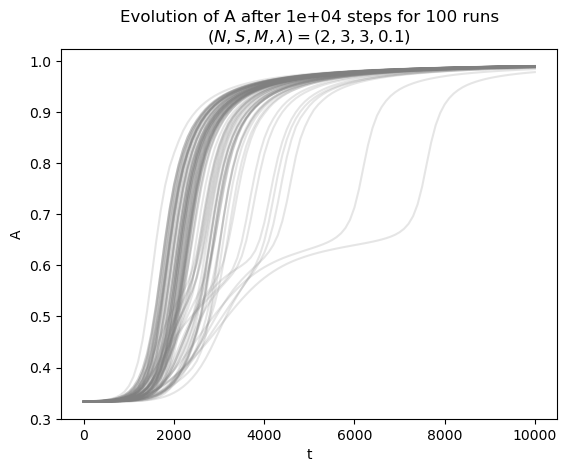

In [21]:
fig_A, ax_A = plt.subplots()
ax_A.set_ylabel('A')
ax_A.set_xlabel('t')

n_runs = 100
show = False

for run in range(n_runs):

    phi_init = run_simple_model(N, S, M, lambd=mu, max_steps=10, get_phi=True)
    y0 = phi_to_y(phi_init, N=N, S=S, M=M)
    tf = 10000
    t_eval = np.arange(0, tf+100, 100)
    sol = solve_ivp(func, t_span=[0, tf], t_eval=t_eval, y0=y0, method='RK45', vectorized=True, args=(mu, N, M, S))

    y_initial, y_final = sol.y[:,0], sol.y[:,-1]
    phi_initial, phi_final = y_to_phi(y_initial,  N=N, S=S, M=M), y_to_phi(y_final,  N=N, S=S, M=M)
    A_init, A_final = intelligibility(phi_initial, N, S, M), intelligibility(phi_final, N, S, M)

    # print(f'\nA initial = {A_init:.4f}\nA final   = {A_final:.4f}')

    if A_final < 0.90*(S/M): plot_before_after(phi_initial, phi_final, tf) # the weird cases
        
    As = []
    for t in range(len(t_eval)):
        y = sol.y[:,t]
        phi = y_to_phi(y, N=N, S=S, M=M)
        A = intelligibility(phi, N, S, M)
        As.append(A)
    
    if show: plot_before_after(phi_initial, phi_final, tf, run, y_final.max())

    ax_A.plot(t_eval, As, alpha=0.2, color='gray')

ax_A.set_title(f'Evolution of A after {tf:.0e} steps for {n_runs} runs\n$(N, S, M, \lambda) = ({N}, {S}, {M}, {mu})$')
# ax_A.legend()
plt.show()

Comparing the predictions of LSA to the strength of the fluctuations in the stochastic model

In [13]:
def grid_display(phi, N=N, S=S, M=M, eps=None):
    
    cmap = 'OrRd'
    figsize = (5*(M/S)*(N/2),5)
    fig, axs = plt.subplots(ncols=N, figsize=figsize, sharey=True)
    fig.subplots_adjust(top=0.8)
    axs[0].set_ylabel('S')
    for idx, ax in enumerate(axs):
        ax.matshow(phi[idx,:,:], cmap=cmap, vmin=0, vmax=1)
        ax.set_xlabel('M')
        for s in range(S):
            for m in range(M):
                ax.text(m, s, f'{phi[idx,s,m]:.2f}', ha='center', va='center')

    if eps is not None: title = f'initial sub-optimal grammar $(\epsilon = {eps:.2f})$'
    else: title = 'initial sub-optimal grammar'
    fig.suptitle(title, y=0.75)
    plt.show()

def investigate_fluctuations(N=2, S=3, M=3, mu=mu, tf=10000, focused=False):

    fig, ax = plt.subplots()

    epsilons = np.linspace(0, 1/(S-1), 11) # unphysical beyond 1/(S-1)
    if focused: epsilons = np.linspace(1/S - 0.05, 1/S + 0.05, 31)
    opt_grammar = optimal_grammar(N=N, S=S, M=M)
    t_eval = np.arange(0, tf+100, 100)
    eval_times = len(t_eval)

    for eps in epsilons:

        phi_init = suboptimal_grammar(opt_grammar, N=N, S=S, M=M, epsilon=eps, method='uniform')

        # grid_display(phi_init, N, S, M, eps)

        y0 = phi_to_y(phi_init, N=N, S=S, M=M)
        sol = solve_ivp(func, t_span=[0, tf], t_eval=t_eval, y0=y0, method='RK45', vectorized=True, args=(mu, N, M, S))

        y_final = sol.y[:,-1]
        phi_final = y_to_phi(y_final, N=N, S=S, M=M)

        diffs = []
        for t in range(eval_times): diffs.append(difference(y_to_phi(sol.y[:,t], N=N, S=S, M=M), opt_grammar) / (N*(S-1)*M)) 
        # normalise the difference: 0 = no difference, 1 = completely different but satisfying the constraint

        print(f'epsilon = {eps:.2f} --- diff = {diffs[-1]:9.6f}')

        if focused: ax.plot(t_eval, diffs, alpha=0.3, color='gray')
        else: ax.plot(t_eval, diffs, label=f'$\epsilon = {eps:.2f}$', alpha=0.5)

    # stochastic_diffs = run_model_diffs(opt_grammar, tf, t_eval, N, S, M)
    # ax.plot(t_eval, stochastic_diffs, 'k', label='stochastic model')

    ax.set_xlabel('integration time')
    ax.set_ylabel('difference to optimal grammar')
    if focused: 
        title = f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$ | ${min(epsilons):.2f} < \epsilon < {max(epsilons):.2f}$'
    else:
        ax.legend()
        title = f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$'
    ax.set_title(title)

    plt.show()

epsilon = 0.28 --- diff =  0.010239
epsilon = 0.29 --- diff =  0.010318
epsilon = 0.29 --- diff =  0.010409
epsilon = 0.29 --- diff =  0.010516
epsilon = 0.30 --- diff =  0.010597
epsilon = 0.30 --- diff =  0.010705
epsilon = 0.30 --- diff =  0.010839
epsilon = 0.31 --- diff =  0.011033
epsilon = 0.31 --- diff =  0.011177
epsilon = 0.31 --- diff =  0.011441
epsilon = 0.32 --- diff =  0.011723
epsilon = 0.32 --- diff =  0.012102
epsilon = 0.32 --- diff =  0.012629
epsilon = 0.33 --- diff =  0.013498
epsilon = 0.33 --- diff =  0.014636
epsilon = 0.33 --- diff =  0.666667
epsilon = 0.34 --- diff =  0.965996
epsilon = 0.34 --- diff =  0.969798
epsilon = 0.34 --- diff =  0.971248
epsilon = 0.35 --- diff =  0.973467
epsilon = 0.35 --- diff =  0.974452
epsilon = 0.35 --- diff =  0.974767
epsilon = 0.36 --- diff =  0.975603
epsilon = 0.36 --- diff =  0.976207
epsilon = 0.36 --- diff =  0.976689
epsilon = 0.37 --- diff =  0.977076
epsilon = 0.37 --- diff =  0.977339
epsilon = 0.37 --- diff =  0

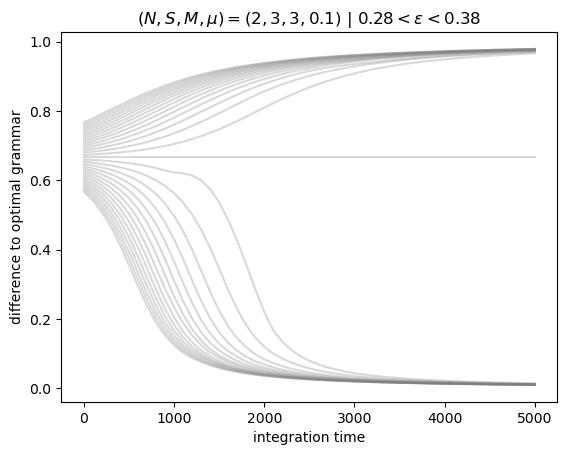

In [15]:
investigate_fluctuations(S=3, M=3, mu=0.1, tf=5000, focused=True)

KeyboardInterrupt: 

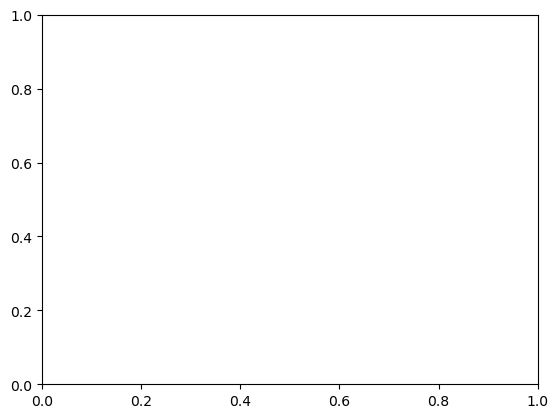

In [12]:
def stochastic_fluctuations(N=N, S=S, M=M, mu=mu):

    opt_grammar  = optimal_grammar(N=N, S=S, M=M)
    sub_opt = suboptimal_grammar(opt_grammar, N, S, M, epsilon=0.0001)

    tf = 10000000
    t_eval = np.arange(tf, step=1000)

    fig, ax = plt.subplots()
    stochastic_diffs = run_model_diffs(sub_opt, opt_grammar, tf, t_eval, N=N, S=S, M=M, mu=mu)
    ax.plot(t_eval, stochastic_diffs, 'k', label='stochastic model')

    ax.set_xlabel('timestep')
    ax.set_ylabel('difference to optimal grammar')
    ax.legend()
    ax.set_title(f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$')

    plt.show()

stochastic_fluctuations()
    

investigating the convergence to an optimal grammar, depending on the parameters of the system

### N-dependence

2
5
8


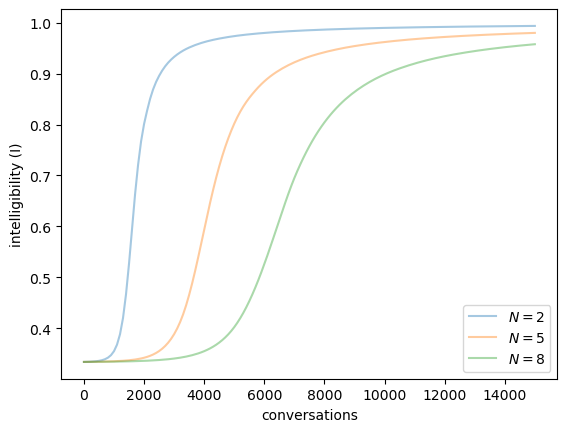

In [38]:
fig, ax = plt.subplots()
ax.set_ylabel('intelligibility (I)')
ax.set_xlabel('conversations')

S, M, mu = 3, 3, 0.1

for N in [2, 5, 8]:

    print(N)

    phi_init = initiate_phi(N, S, M, method='diag_val', diag_val=1/S+0.005*S)
    y0 = phi_to_y(phi_init, N=N, S=S, M=M)
    tf = 15000
    t_eval = np.arange(0, tf+100, 100)
    sol = solve_ivp(func, t_span=[0, tf], t_eval=t_eval, y0=y0, method='RK45', vectorized=True, args=(mu, N, M, S))
    Is = []
    for t in range(len(t_eval)):
        y = sol.y[:,t]
        phi = y_to_phi(y, N=N, S=S, M=M)
        I = intelligibility(phi, N, S, M)
        Is.append(I)
    
    # if show: plot_before_after(phi_initial, phi_final, tf, run, y_final.max())

    ax.plot(t_eval, Is, alpha=0.4, label=f'$N = {N}$')

ax.legend()
plt.show()

### symmetric systems (M=S)

3
101
(18, 101)
4
101
(32, 101)
5
101
(50, 101)
6
101
(72, 56)


IndexError: index 56 is out of bounds for axis 1 with size 56

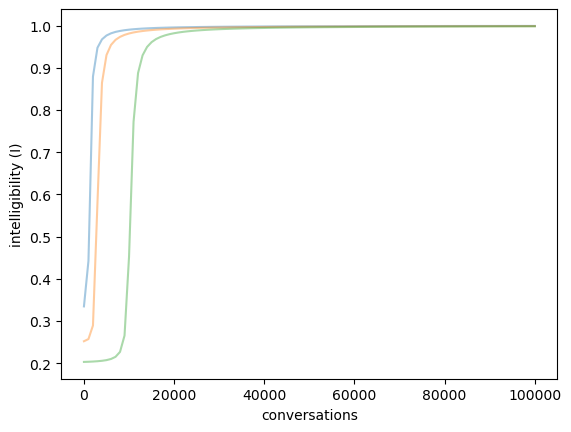

In [37]:
fig, ax = plt.subplots()
ax.set_ylabel('intelligibility (I)')
ax.set_xlabel('conversations')

N, mu = 2, 0.1

for S in range(3, 8):

    M = S # symmetric system
    print(S)

    phi_init = initiate_phi(N, S, M, method='diag_val', diag_val=1/S+0.01*S)
    # phi_init = phi_init /
    y0 = phi_to_y(phi_init, N=N, S=S, M=M)
    tf = 100000
    t_eval = np.arange(0, tf+1000, 1000)
    print(len(t_eval))
    sol = solve_ivp(func, t_span=[0, tf], t_eval=t_eval, y0=y0, method='RK45', vectorized=True, args=(mu, N, S, M))

    print(sol.y.shape)

    Is = []
    for t in range(len(t_eval)):
        y = sol.y[:,t]
        phi = y_to_phi(y, N=N, S=S, M=M)
        I = intelligibility(phi, N, S, M)
        Is.append(I)

    ax.plot(t_eval, Is, alpha=0.4, label=f'$(S,M) = ({S},{M})$')

ax.legend()
plt.show()

In [ ]:
# another idea: compare that graph with the averaged out intelligibility from stochastic simulations

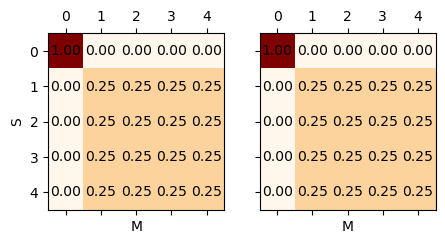

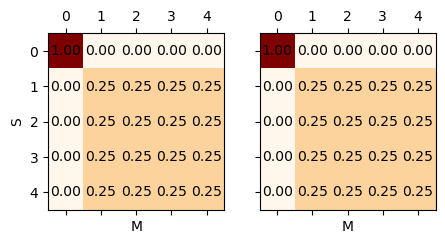

In [16]:
# deterministic prediction for different initial phis

N, S, M, lambd = 2, 5, 5, 0.1
phi_init = np.ones((N,S,M)) * 1/S
val = 1
for i in range(N):
    for s in range(S):
        for m in range(M):
            if m==0:
                if s==0: phi_init[i,s,m] = val
                else: phi_init[i,s,m] = (1-val)/4
            elif  m!=0 and s==0: phi_init[i,s,m] = (1-val)/4
            else: phi_init[i,s,m] = (1-(1-val)/4)/4

grid_display(phi_init, N, S, M, with_title=False)

t_eval, phis = get_deterministic_predictions(N, S, M, lambd, phi_initial=phi_init, get_intelligibility=False)
grid_display(phis[-1], N, S, M, with_title=False)